<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    ML for Bioinformatics <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
<font color=3C99D size=5>
    Homework 3: Practical - Multi-Layer Perceptron (VAE) <br>
<font color=696880 size=4>
    Sobhan Moghimi (sobhanmoghimi45@gmail.com) <br>
    Fakhredin Abdi (fakhredinabdi80@gmail.com) <br>
    
____


### Full Name : Javad Razi
### Student Number : 401204354
__

# Description

**In this assignment you'll be working with Dorothea Dataset.**

DOROTHEA is a drug discovery dataset. Chemical compounds represented by structural molecular features must be classified as active (binding to thrombin) or inactive.
To find out more about dataset, refer to this link: https://archive.ics.uci.edu/ml/datasets/Dorothea

You should implement a classifier with Neural Networks and for this purpose we will be using PyTorch as framework.

# Importing libraries, modules and Dataset.

In this part, import all the libraries and modules needed to solve the problem.

In [1]:
import os
import glob
import random
import urllib.request
import numpy as np
import pandas as pd
import scipy as sp
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt

Now import the train and test data from dataset.

In [2]:
def download_and_save(url, file_path):
    print("File doesn't exist locally. Going to download from ", url)
    urllib.request.urlretrieve(url, file_path)
    print("File downloaded and stored in ", file_path)


# Check if the CSV files exist in the ./data folder
data_directory = "./data/"
os.makedirs(data_directory, exist_ok=True)

train_data_file = "dorothea_train.data"
train_labels_file = "dorothea_train.labels"
test_data_file = "dorothea_test.data"
validation_data_file = "dorothea_valid.data"
validation_labels_file = "dorothea_valid.labels"

urls = {
    train_data_file: "https://archive.ics.uci.edu/ml/machine-learning-databases/dorothea/DOROTHEA/dorothea_train.data",
    train_labels_file: "https://archive.ics.uci.edu/ml/machine-learning-databases/dorothea/DOROTHEA/dorothea_train.labels",
    validation_data_file: "https://archive.ics.uci.edu/ml/machine-learning-databases/dorothea/DOROTHEA/dorothea_valid.data",
    validation_labels_file: "https://archive.ics.uci.edu/ml/machine-learning-databases/dorothea/dorothea_valid.labels",
    test_data_file: "https://archive.ics.uci.edu/ml/machine-learning-databases/dorothea/DOROTHEA/dorothea_test.data",
}

for file_name, url in urls.items():
    file_path = os.path.join(data_directory, file_name)
    if not os.path.exists(file_path):
        download_and_save(url, file_path)

In [3]:
def load_sparse_matrix(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()

    values = np.zeros(shape=(len(lines), 100000), dtype=int)

    for ind, line in enumerate(lines):
        vals = np.array(list(map(float, line.strip().split())), dtype=int)
        for v in vals:
            values[ind, v - 1] = 1

    return csr_matrix(values)


def load_labels(file_path):
    return np.fromfile(file_path, sep="\r\n")


# Read the CSV files from local computer
train_data = load_sparse_matrix(os.path.join(data_directory, train_data_file))
train_labels = load_labels(os.path.join(data_directory, train_labels_file))
validation_data = load_sparse_matrix(os.path.join(data_directory, validation_data_file))
validation_labels = load_labels(os.path.join(data_directory, validation_labels_file))
test_data = load_sparse_matrix(os.path.join(data_directory, test_data_file))

print("Train Data Shape", train_data.shape)
print("Train Labels Shape", train_labels.shape)
print("Validation Data Shape", validation_data.shape)
print("Validation Labels Shape", validation_labels.shape)
print("Test Data Shape", test_data.shape)

Train Data Shape (800, 100000)
Train Labels Shape (800,)
Validation Data Shape (350, 100000)
Validation Labels Shape (350,)
Test Data Shape (208, 100000)


## Normalize
You can normalize your data using <code>Scikit-Learn</code> modules here.

In [4]:
# Apply normalization here
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler


scaler = MaxAbsScaler()

train_data = scaler.fit_transform(train_data)
validation_data = scaler.transform(validation_data)
test_data = scaler.transform(test_data)

In [5]:
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
validation_labels = label_encoder.fit_transform(validation_labels)

labels_df = pd.DataFrame(
    {
        "Train Labels": [(train_labels == 0).sum(), (train_labels == 1).sum()],
        "Validation Labels": [
            (validation_labels == 0).sum(),
            (validation_labels == 1).sum(),
        ],
    },
    index=[0, 1],
)

train_labels = train_labels.reshape(-1, 1)
validation_labels = validation_labels.reshape(-1, 1)

labels_df.head()

,Train Labels,Validation Labels
0,722,316
1,78,34


<font face="'Roboto', 'Roboto Slab', 'Garamond'" size=4><div align='justify'>
### Exploring Density of Datasets
As mentioned in the description of dataset, the dataset is a binary sparse matrix. Here, we compare the sparsity of training set vs validation set vs test set. As shown in the plots, the training matrix has siginificantly lower density, and non-zero elements cannot be seen with the specified resolution. The validation set is more dense and non-zero elements can be observed in the output image. Finally, as shown in the output image, the test set has the most density between the three sets. 

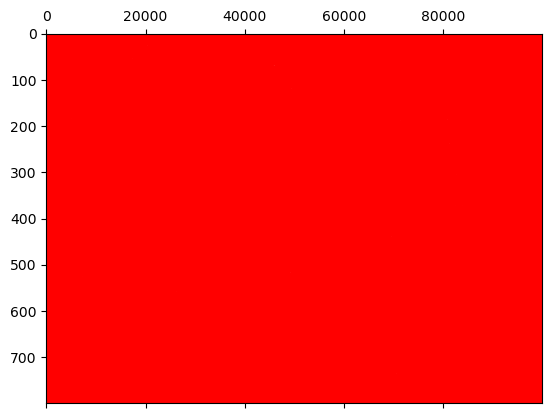

In [6]:
plt.spy(train_data, color="red", markersize=0.5, aspect="auto")
plt.show()

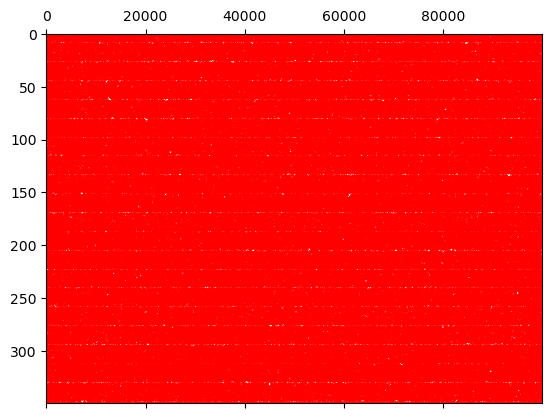

In [7]:
plt.spy(validation_data, color="red", markersize=0.5, aspect="auto")
plt.show()

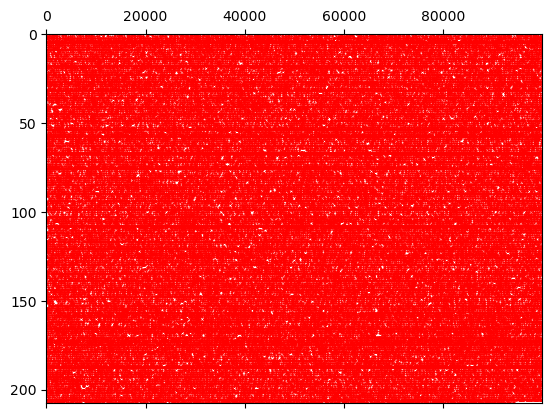

In [8]:
plt.spy(test_data, color="red", markersize=0.5, aspect="auto")
plt.show()

## Dimensionality Reduction
There are too many attributes for each instance of dataset. We will suffer from sparse data and long training phase. Thus you can reduce dimensions to get better accuracy. 

Principal component analysis (PCA) is the process of computing the principal components and using them to perform a change of basis on the data.

Apply PCA on Dorothea dataSet using <code>Scikit-Learn</code>.

In [9]:
from IPython.display import display

# Since pca doesn't support sparse matrix (as the output of pca will not be sparse)
# we convert matrices to dense format
train_data = np.asarray(csr_matrix(train_data).todense())
validation_data = np.asarray(csr_matrix(validation_data).todense())
test_data = np.asarray(csr_matrix(test_data).todense())

display("Train Data", "Shape {}".format(train_data.shape), train_data)
display("Validation Data", "Shape {}".format(validation_data.shape), validation_data)
display("Test Data", "Shape {}".format(test_data.shape), test_data)

'Train Data'

'Shape (800, 100000)'

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

'Validation Data'

'Shape (350, 100000)'

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

'Test Data'

'Shape (208, 100000)'

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
NUM_OF_FEATURES = 100
# Apply PCA here
pca = PCA(n_components=NUM_OF_FEATURES)
train_data = pca.fit_transform(train_data)
validation_data = pca.transform(validation_data)
test_data = pca.transform(test_data)

display("Train Data", "Shape {}".format(train_data.shape), train_data)
display("Validation Data", "Shape {}".format(validation_data.shape), validation_data)
display("Test Data", "Shape {}".format(test_data.shape), test_data)

'Train Data'

'Shape (800, 100)'

array([[-1.12594189, -0.12853964, -0.10261027, ...,  0.54897318,
         0.47800301, -0.97349767],
       [-1.30814079,  0.19336024, -0.40467886, ...,  0.10636617,
        -1.04942649,  0.08974838],
       [-1.4047866 ,  0.09793614, -0.34462693, ...,  0.95288387,
         0.56128796,  0.41135686],
       ...,
       [ 4.85006219, -4.8582211 ,  3.79210439, ..., -3.56802268,
        -0.50133382,  3.10538399],
       [-1.22666389,  0.28152404, -0.44209537, ..., -0.41969957,
         0.31770716,  0.40698843],
       [-1.4110797 ,  0.39486582, -0.20271097, ..., -1.30686419,
         2.10492361, -0.38814431]])

'Validation Data'

'Shape (350, 100)'

array([[-0.58552399, -0.24289188, -0.09978546, ...,  0.21076621,
        -0.00399446, -0.1794792 ],
       [-1.1534196 ,  0.05895419, -0.12340462, ...,  0.02992256,
        -0.05265271, -0.13892299],
       [-0.74395026,  0.78507556,  0.60960939, ..., -0.25755644,
        -0.18817783,  0.09173035],
       ...,
       [-0.97421735,  0.20898754, -0.45769811, ...,  0.1000226 ,
        -0.10714878, -0.06833981],
       [-1.12146924,  0.73907515,  0.26956943, ...,  0.08091194,
         0.47451438,  0.20911693],
       [-1.27863266,  0.06709088, -0.271849  , ...,  0.00395574,
        -0.15361551,  0.02942667]])

'Test Data'

'Shape (208, 100)'

array([[-9.90831625e-01,  4.39675410e-01, -1.52206847e-01, ...,
         1.47855067e-02, -1.36361541e-01, -6.47054666e-02],
       [-1.15976794e+00,  2.15690754e-01, -9.59490323e-02, ...,
        -2.02495120e-01, -2.61021958e-01,  1.83945749e-01],
       [ 1.86382362e+00,  1.94679530e+00, -2.65106759e+00, ...,
        -4.66369535e-02,  7.61090206e-02, -2.09215281e-01],
       ...,
       [-1.00500890e+00,  3.23269317e-01,  2.29475809e-03, ...,
         4.74198414e-02, -2.29388487e-01,  2.64478390e-01],
       [ 5.97248421e+00, -3.64514195e+00,  2.84967935e+00, ...,
        -8.32803660e-02,  2.66355817e-01, -1.42155081e-01],
       [-8.77940496e-01, -2.92367556e-02, -1.28572232e-01, ...,
        -4.74911591e-03,  6.35348091e-02, -2.18560964e-02]])

# Define Model



In [11]:
# Define your model in here
# You can change the code below.


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(NUM_OF_FEATURES, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Train the model

**Initialize model, define hyperparameters, optimizer, loss function, etc.**



<font face="'Roboto', 'Roboto Slab', 'Garamond'" size=4><div align='justify'>
Since the test data didn't contain any labels, we use the validation dataset as our test set. (We never use the original validation dataset during training) Since we still want a validation set using the early stopping technique, we split the original training dataset into two separate sets. One for training, and one for validtion. (Again, the original validation dataset is used for the final test and is NOT touched during training)

In [12]:
# Split the data into test and training sets
from sklearn.model_selection import train_test_split


(
    train_data_sp,
    validation_data_sp,
    train_labels_sp,
    validation_labels_sp,
) = train_test_split(
    train_data,
    train_labels,
    test_size=0.2,
    stratify=train_labels,
    shuffle=True,
    random_state=27920,
)

train_data, validation_data, test_data = (
    train_data_sp,
    validation_data_sp,
    validation_data,
)
train_labels, validation_labels, test_labels = (
    train_labels_sp,
    validation_labels_sp,
    validation_labels,
)

In [13]:
# Implement Train in here
model = Classifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_achieved_loss = np.inf
patience = 5
epochs = 100
loss_values = []

for epoch in range(epochs):
    inputs = torch.tensor(train_data, dtype=torch.float32)
    labels = torch.tensor(train_labels, dtype=torch.float32)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_inputs = torch.tensor(validation_data, dtype=torch.float32)
        val_labels = torch.tensor(validation_labels, dtype=torch.float32)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

    # Early stopping check
    if val_loss < best_achieved_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter > patience:
            print(f"Stopping early after {epoch} epochs.")
            break

    loss_values.append(loss.item())

model.load_state_dict(best_model_state)

<All keys matched successfully>

**After the training process, plot metrics such as loss function values.**

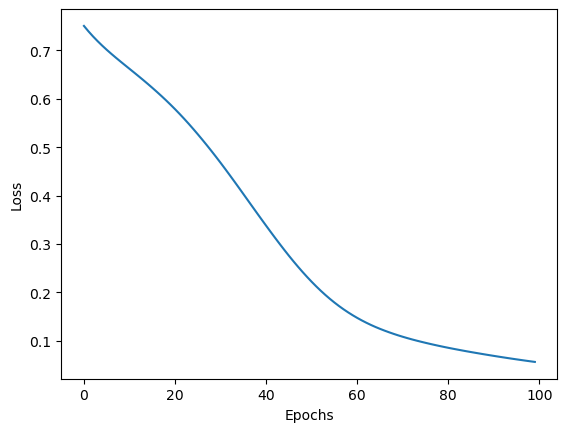

In [14]:
# Plot in here
plt.plot(loss_values)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Testing
After training, test your model on test dataset and compute performance metrics. 

In [15]:
# Implement Test in here
with torch.no_grad():
    test_inputs = torch.tensor(test_data, dtype=torch.float32)
    test_outputs = model(test_inputs)
    predictions = (test_outputs > 0.5).float().numpy()

print("Accuracy Score:", accuracy_score(test_labels, predictions))

clf_report = classification_report(test_labels, predictions, output_dict=True)
display("Classification Report", pd.DataFrame(clf_report))

Accuracy Score: 0.9342857142857143


'Classification Report'

,0,1,accuracy,macro avg,weighted avg
precision,0.956386,0.689655,0.934286,0.823021,0.930475
recall,0.971519,0.588235,0.934286,0.779877,0.934286
f1-score,0.963893,0.634921,0.934286,0.799407,0.931936
support,316.000000,34.000000,0.934286,350.000000,350.000000


Show confusion matrix of your model.

<font face="'Roboto', 'Roboto Slab', 'Garamond'" size=4><div align='justify'>
The entries in confusion matrix are normalized so that top-left and bottom-right entries represent the sensitivity and specificity of the model, respectively.

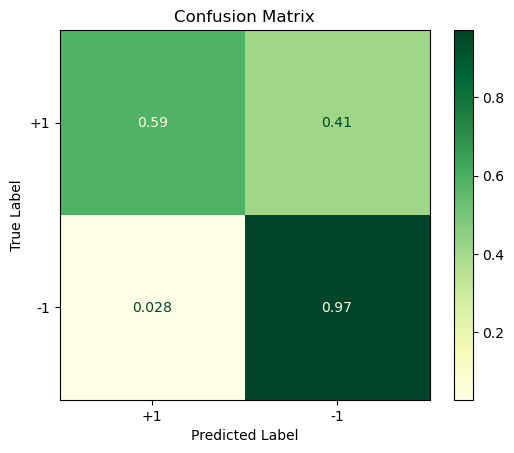

In [16]:
# Print your confusion matrix here.
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


# create display object
disp = ConfusionMatrixDisplay.from_predictions(
    test_labels,
    predictions,
    display_labels=["+1", "-1"],
    labels=[1, 0],
    cmap="YlGn",
    normalize="true",
)


plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()